## Setup

In [3]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image

sys.path.insert(0, os.path.abspath('../'))

from src.input_alignment import (
    compute_lab_statistics,
    apply_lab_alignment,
    LABAlignmentTransform,
    fourier_domain_adaptation,
    apply_fda,
    FDATransform,
    visualize_fda,
    compare_fda_lab
)
from src.dataset.loaders import get_dataloaders, compute_class_weights
from src.utils.metrics import calculate_metrics

SEED = 21
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
IMG_SIZE = 224

# Directories
NOTEBOOK_DIR = Path(os.getcwd())
RESULTS_DIR = NOTEBOOK_DIR / 'notebooks' / 'results' / 'input_alignment'
DATA_DIR = NOTEBOOK_DIR / 'data'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Data directory: {DATA_DIR}")

Device: mps
Results directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/input_alignment
Data directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/data


## Step 1: Compute Source Domain Statistics

Extract LAB color statistics from ASDID dataset to use as reference.

In [4]:
# Load ASDID dataset (source domain)
print("Loading ASDID dataset (source domain)...")

# Standard transforms (no augmentation for statistics computation)
eval_transforms = T.Compose([
    T.Resize(int(IMG_SIZE * 1.14)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
])

_, _, _, asdid_dataset, _, _, _ = get_dataloaders(
    dataset_name='ASDID',
    data_root=str(DATA_DIR / 'ASDID'),
    batch_size=BATCH_SIZE,
    train_transform=eval_transforms,
    test_transform=eval_transforms,
    seed=SEED
)

print(f"ASDID dataset: {len(asdid_dataset)} images")
print(f"Classes: {list(asdid_dataset.class_to_idx.keys())}")

Loading ASDID dataset (source domain)...
Loaded 4799 samples for ASDID dataset.
ASDID dataset: 4799 images
Classes: ['Healthy', 'Rust', 'Frogeye']


In [5]:
# Compute LAB statistics from source domain
print("\nComputing LAB color statistics from ASDID...")
source_lab_stats = compute_lab_statistics(asdid_dataset, num_samples=500)

# Save statistics for later use
lab_transform = LABAlignmentTransform(source_lab_stats)
lab_transform.save(RESULTS_DIR / 'asdid_lab_stats.pkl')

print(f"\n✅ Source LAB statistics computed and saved")


Computing LAB color statistics from ASDID...
LAB Statistics computed from 25088000 pixels:
  A channel: mean=-12.15, std=10.42
  B channel: mean=26.48, std=15.42
LAB statistics saved to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/input_alignment/asdid_lab_stats.pkl

✅ Source LAB statistics computed and saved


## Step 2: Visualize Alignment Methods

Compare original vs LAB vs FDA on sample images.

In [6]:
# Get sample images from MH (target domain)
mh_rust_dir = DATA_DIR / 'MH-SoyaHealthVision' / 'Soyabean_Leaf_Image_Dataset' / 'Soyabean_Rust'
mh_sample_images = list(mh_rust_dir.glob('*.[jJ][pP][gG]'))[:3]

# Get sample images from ASDID (source domain) for FDA
asdid_rust_dir = DATA_DIR / 'ASDID' / 'soybean_rust'
asdid_sample_images = list(asdid_rust_dir.glob('*.[jJ][pP][gG]'))[:5]

print(f"MH samples: {len(mh_sample_images)}")
print(f"ASDID samples for FDA: {len(asdid_sample_images)}")

MH samples: 3
ASDID samples for FDA: 5


In [7]:
# Visualize LAB alignment
from src.input_alignment.lab_alignment import visualize_lab_alignment

print("Visualizing LAB alignment...")
fig = visualize_lab_alignment(
    str(mh_sample_images[0]),
    source_lab_stats,
    save_path=RESULTS_DIR / 'lab_alignment_example.png'
)
plt.show()

Visualizing LAB alignment...
Visualization saved to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/input_alignment/lab_alignment_example.png


In [8]:
# Visualize FDA with different betas
print("\nVisualizing FDA with different β values...")
fig = visualize_fda(
    str(mh_sample_images[0]),
    str(asdid_sample_images[0]),
    betas=[0.01, 0.05, 0.1],
    save_path=RESULTS_DIR / 'fda_beta_comparison.png'
)
plt.show()

print("\n📊 FDA Beta Guidelines:")
print("  • β=0.01: Subtle (replace 1% center = pure illumination)")
print("  • β=0.05: Moderate (replace 5% center = color + some texture)")
print("  • β=0.1:  Aggressive (replace 10% center = more style transfer)")


Visualizing FDA with different β values...
Visualization saved to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/input_alignment/fda_beta_comparison.png



📊 FDA Beta Guidelines:
  • β=0.01: Subtle (replace 1% center = pure illumination)
  • β=0.05: Moderate (replace 5% center = color + some texture)
  • β=0.1:  Aggressive (replace 10% center = more style transfer)



Comparing LAB alignment vs FDA...


/Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/src/input_alignment/lab_alignment.py:62: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 15 negative Z values that have been clipped to zero
  rgb = color.lab2rgb(lab_image)


Comparison saved to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/input_alignment/lab_vs_fda_comparison.png


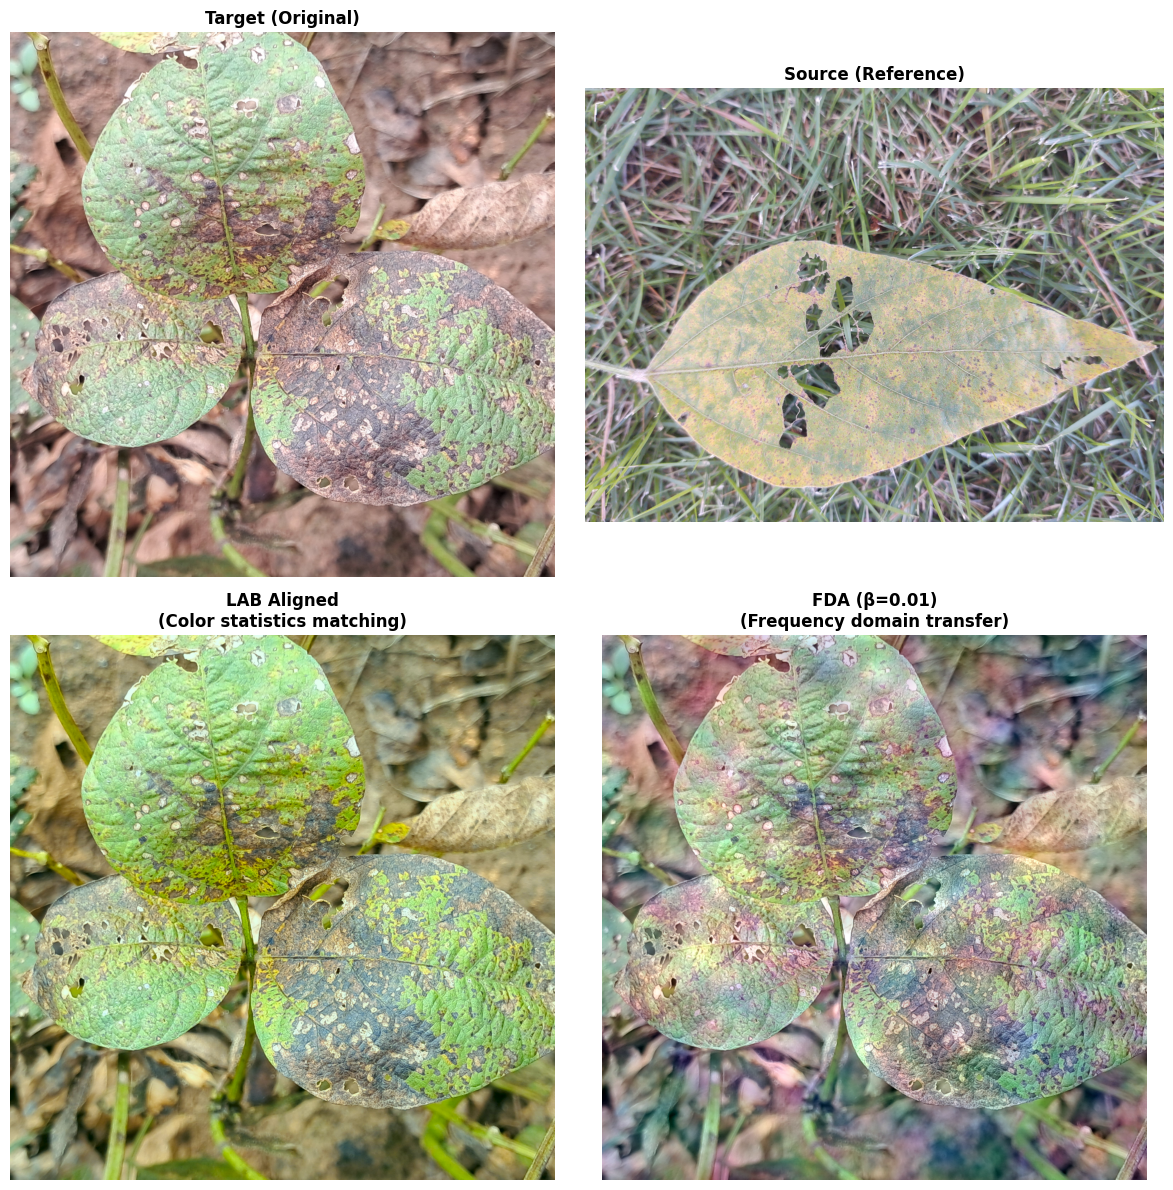


📊 Key Differences:
  • LAB: Matches color statistics only (simple, fast)
  • FDA: Transfers frequency components (more sophisticated)
  • LAB is deterministic, FDA can use different source images


In [9]:
# Compare LAB vs FDA side by side
print("\nComparing LAB alignment vs FDA...")
fig = compare_fda_lab(
    str(mh_sample_images[1]),
    str(asdid_sample_images[1]),
    source_lab_stats,
    beta=0.01,
    save_path=RESULTS_DIR / 'lab_vs_fda_comparison.png'
)
plt.show()

print("\n📊 Key Differences:")
print("  • LAB: Matches color statistics only (simple, fast)")
print("  • FDA: Transfers frequency components (more sophisticated)")
print("  • LAB is deterministic, FDA can use different source images")

## Step 3: Load Pre-trained Model

We'll use a ResNet50 model trained on ASDID from the baseline experiments.
If not available, we can train a new one quickly.

In [12]:
# Check if we have a pre-trained model from previous notebooks
pretrained_model_path = NOTEBOOK_DIR / 'notebooks'/ 'results' / 'best_resnet50.pth'

if pretrained_model_path.exists():
    print(f"✅ Found pre-trained ResNet50 model: {pretrained_model_path}")
    use_pretrained = True
else:
    print("⚠️ No pre-trained model found. Will train a new one.")
    use_pretrained = False

# Initialize model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(DEVICE)

if use_pretrained:
    checkpoint = torch.load(pretrained_model_path, map_location=DEVICE)
    # Extract model state dict from checkpoint
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    print("✅ Loaded pre-trained weights")
else:
    print("⚠️ Using ImageNet initialization only")

print(f"\nModel: ResNet50 (25.6M params)")
print(f"Device: {DEVICE}")

✅ Found pre-trained ResNet50 model: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/best_resnet50.pth
✅ Loaded pre-trained weights

Model: ResNet50 (25.6M params)
Device: mps


## Step 4: Evaluate Without Alignment (Baseline)

Test the model on MH dataset without any alignment.

In [13]:
# Load MH test set (no alignment)
print("Loading MH test set (no alignment)...")

# Standard transforms with normalization
test_transforms = T.Compose([
    T.Resize(int(IMG_SIZE * 1.14)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

_, _, mh_test_loader, mh_dataset, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root=str(DATA_DIR / 'MH-SoyaHealthVision' / 'Soyabean_Leaf_Image_Dataset'),
    batch_size=BATCH_SIZE,
    train_transform=test_transforms,
    test_transform=test_transforms,
    seed=SEED
)

print(f"MH Test Set: {len(mh_test_loader.dataset)} images")
print(f"Classes: {list(mh_dataset.class_to_idx.keys())}")

Loading MH test set (no alignment)...
Loaded 1225 samples for MH dataset.
MH Test Set: 185 images
Classes: ['Healthy', 'Rust', 'Frogeye']


In [14]:
def evaluate_model(model, test_loader, model_name, device=DEVICE):
    """Evaluate model and return metrics"""
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Compute metrics
    metrics = calculate_metrics(all_labels, all_preds)
    
    return metrics, all_labels, all_preds

# Evaluate baseline (no alignment)
print("\n" + "="*70)
print("Evaluating BASELINE (No Alignment) on MH")
print("="*70)

baseline_metrics, baseline_labels, baseline_preds = evaluate_model(model, mh_test_loader, "Baseline")

print(f"\nBaseline Performance (MH):")
print(f"  Accuracy:  {baseline_metrics['accuracy']:.4f}")
print(f"  Precision: {baseline_metrics['precision']:.4f}")
print(f"  Recall:    {baseline_metrics['recall']:.4f}")
print(f"  F1 Score:  {baseline_metrics['f1']:.4f}")


Evaluating BASELINE (No Alignment) on MH


Evaluating Baseline:   0%|          | 0/6 [00:00<?, ?it/s]


Baseline Performance (MH):
  Accuracy:  0.7405
  Precision: 0.7123
  Recall:    0.7758
  F1 Score:  0.7185


## Step 5: Evaluate with LAB Alignment

Apply LAB color alignment to target images before inference.

In [15]:
# Create LAB-aligned test set
print("Creating LAB-aligned test set...")

lab_transforms = T.Compose([
    T.Resize(int(IMG_SIZE * 1.14)),
    T.CenterCrop(IMG_SIZE),
    LABAlignmentTransform(source_lab_stats),  # Apply LAB alignment BEFORE normalization
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

_, _, mh_lab_loader, mh_lab_dataset, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root=str(DATA_DIR / 'MH-SoyaHealthVision' / 'Soyabean_Leaf_Image_Dataset'),
    batch_size=BATCH_SIZE,
    train_transform=lab_transforms,
    test_transform=lab_transforms,
    seed=SEED
)

print(f"LAB-aligned Test Set: {len(mh_lab_loader.dataset)} images")

Creating LAB-aligned test set...
Loaded 1225 samples for MH dataset.
LAB-aligned Test Set: 185 images


In [16]:
# Evaluate with LAB alignment
print("\n" + "="*70)
print("Evaluating LAB ALIGNMENT on MH")
print("="*70)

lab_metrics, lab_labels, lab_preds = evaluate_model(model, mh_lab_loader, "LAB-Aligned")

print(f"\nLAB Alignment Performance (MH):")
print(f"  Accuracy:  {lab_metrics['accuracy']:.4f}")
print(f"  Precision: {lab_metrics['precision']:.4f}")
print(f"  Recall:    {lab_metrics['recall']:.4f}")
print(f"  F1 Score:  {lab_metrics['f1']:.4f}")

# Compare to baseline
f1_improvement = lab_metrics['f1'] - baseline_metrics['f1']
print(f"\nImprovement over baseline: {f1_improvement:+.4f} ({f1_improvement/baseline_metrics['f1']*100:+.1f}%)")


Evaluating LAB ALIGNMENT on MH


Evaluating LAB-Aligned:   0%|          | 0/6 [00:00<?, ?it/s]


LAB Alignment Performance (MH):
  Accuracy:  0.7405
  Precision: 0.6958
  Recall:    0.7899
  F1 Score:  0.7107

Improvement over baseline: -0.0078 (-1.1%)


## Step 6: Evaluate with FDA (β=0.01)

Apply Fourier Domain Adaptation with conservative β.

In [17]:
# Load source images for FDA
print("Loading source images for FDA...")

source_image_paths = []
for class_folder in ['healthy', 'soybean_rust', 'frogeye']:
    folder_path = DATA_DIR / 'ASDID' / class_folder
    source_image_paths.extend(list(folder_path.glob('*.[jJ][pP][gG]')))

# Sample a subset for efficiency
np.random.seed(SEED)
source_image_paths = np.random.choice(source_image_paths, size=min(200, len(source_image_paths)), replace=False)

# Load images
source_images = [Image.open(p).convert('RGB') for p in source_image_paths]
print(f"Loaded {len(source_images)} source images for FDA")

Loading source images for FDA...
Loaded 200 source images for FDA


In [18]:
# Create FDA-aligned test set (β=0.01)
print("Creating FDA-aligned test set (β=0.01)...")

fda_transforms_001 = T.Compose([
    T.Resize(int(IMG_SIZE * 1.14)),
    T.CenterCrop(IMG_SIZE),
    FDATransform(source_images, beta=0.01),  # Apply FDA BEFORE normalization
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

_, _, mh_fda001_loader, mh_fda001_dataset, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root=str(DATA_DIR / 'MH-SoyaHealthVision' / 'Soyabean_Leaf_Image_Dataset'),
    batch_size=BATCH_SIZE,
    train_transform=fda_transforms_001,
    test_transform=fda_transforms_001,
    seed=SEED
)

print(f"FDA (β=0.01) Test Set: {len(mh_fda001_loader.dataset)} images")

Creating FDA-aligned test set (β=0.01)...
FDATransform initialized with 200 source images (beta=0.01)
Loaded 1225 samples for MH dataset.
FDA (β=0.01) Test Set: 185 images


In [19]:
# Evaluate with FDA (β=0.01)
print("\n" + "="*70)
print("Evaluating FDA (β=0.01) on MH")
print("="*70)

fda001_metrics, fda001_labels, fda001_preds = evaluate_model(model, mh_fda001_loader, "FDA-β0.01")

print(f"\nFDA (β=0.01) Performance (MH):")
print(f"  Accuracy:  {fda001_metrics['accuracy']:.4f}")
print(f"  Precision: {fda001_metrics['precision']:.4f}")
print(f"  Recall:    {fda001_metrics['recall']:.4f}")
print(f"  F1 Score:  {fda001_metrics['f1']:.4f}")

# Compare to baseline
f1_improvement = fda001_metrics['f1'] - baseline_metrics['f1']
print(f"\nImprovement over baseline: {f1_improvement:+.4f} ({f1_improvement/baseline_metrics['f1']*100:+.1f}%)")


Evaluating FDA (β=0.01) on MH


Evaluating FDA-β0.01:   0%|          | 0/6 [00:00<?, ?it/s]


FDA (β=0.01) Performance (MH):
  Accuracy:  0.6973
  Precision: 0.6705
  Recall:    0.7441
  F1 Score:  0.6762

Improvement over baseline: -0.0423 (-5.9%)


## Step 7: Evaluate with FDA (β=0.05)

Test more aggressive frequency replacement.

In [20]:
# Create FDA-aligned test set (β=0.05)
print("Creating FDA-aligned test set (β=0.05)...")

fda_transforms_005 = T.Compose([
    T.Resize(int(IMG_SIZE * 1.14)),
    T.CenterCrop(IMG_SIZE),
    FDATransform(source_images, beta=0.05),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

_, _, mh_fda005_loader, mh_fda005_dataset, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root=str(DATA_DIR / 'MH-SoyaHealthVision' / 'Soyabean_Leaf_Image_Dataset'),
    batch_size=BATCH_SIZE,
    train_transform=fda_transforms_005,
    test_transform=fda_transforms_005,
    seed=SEED
)

print(f"FDA (β=0.05) Test Set: {len(mh_fda005_loader.dataset)} images")

Creating FDA-aligned test set (β=0.05)...
FDATransform initialized with 200 source images (beta=0.05)
Loaded 1225 samples for MH dataset.
FDA (β=0.05) Test Set: 185 images


In [21]:
# Evaluate with FDA (β=0.05)
print("\n" + "="*70)
print("Evaluating FDA (β=0.05) on MH")
print("="*70)

fda005_metrics, fda005_labels, fda005_preds = evaluate_model(model, mh_fda005_loader, "FDA-β0.05")

print(f"\nFDA (β=0.05) Performance (MH):")
print(f"  Accuracy:  {fda005_metrics['accuracy']:.4f}")
print(f"  Precision: {fda005_metrics['precision']:.4f}")
print(f"  Recall:    {fda005_metrics['recall']:.4f}")
print(f"  F1 Score:  {fda005_metrics['f1']:.4f}")

# Compare to baseline
f1_improvement = fda005_metrics['f1'] - baseline_metrics['f1']
print(f"\nImprovement over baseline: {f1_improvement:+.4f} ({f1_improvement/baseline_metrics['f1']*100:+.1f}%)")


Evaluating FDA (β=0.05) on MH


Evaluating FDA-β0.05:   0%|          | 0/6 [00:00<?, ?it/s]


FDA (β=0.05) Performance (MH):
  Accuracy:  0.7135
  Precision: 0.6686
  Recall:    0.7517
  F1 Score:  0.6837

Improvement over baseline: -0.0349 (-4.9%)


## Step 8: Final Comparison

Compare all methods side by side.

In [22]:
# Create summary table
summary_data = {
    'Method': ['Baseline (No Alignment)', 'LAB Alignment', 'FDA (β=0.01)', 'FDA (β=0.05)'],
    'F1 Score': [
        baseline_metrics['f1'],
        lab_metrics['f1'],
        fda001_metrics['f1'],
        fda005_metrics['f1']
    ],
    'Accuracy': [
        baseline_metrics['accuracy'],
        lab_metrics['accuracy'],
        fda001_metrics['accuracy'],
        fda005_metrics['accuracy']
    ],
    'Precision': [
        baseline_metrics['precision'],
        lab_metrics['precision'],
        fda001_metrics['precision'],
        fda005_metrics['precision']
    ],
    'Recall': [
        baseline_metrics['recall'],
        lab_metrics['recall'],
        fda001_metrics['recall'],
        fda005_metrics['recall']
    ],
    'F1 Improvement': [
        0.0,
        lab_metrics['f1'] - baseline_metrics['f1'],
        fda001_metrics['f1'] - baseline_metrics['f1'],
        fda005_metrics['f1'] - baseline_metrics['f1']
    ]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("INPUT ALIGNMENT EXPERIMENT - FINAL RESULTS")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Save summary
df_summary.to_csv(RESULTS_DIR / 'input_alignment_summary.csv', index=False)
print(f"\n💾 Summary saved to: {RESULTS_DIR / 'input_alignment_summary.csv'}")


INPUT ALIGNMENT EXPERIMENT - FINAL RESULTS
                 Method  F1 Score  Accuracy  Precision   Recall  F1 Improvement
Baseline (No Alignment)  0.718527  0.740541   0.712284 0.775763        0.000000
          LAB Alignment  0.710704  0.740541   0.695823 0.789885       -0.007823
           FDA (β=0.01)  0.676211  0.697297   0.670466 0.744063       -0.042317
           FDA (β=0.05)  0.683661  0.713514   0.668601 0.751696       -0.034866

💾 Summary saved to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/input_alignment/input_alignment_summary.csv


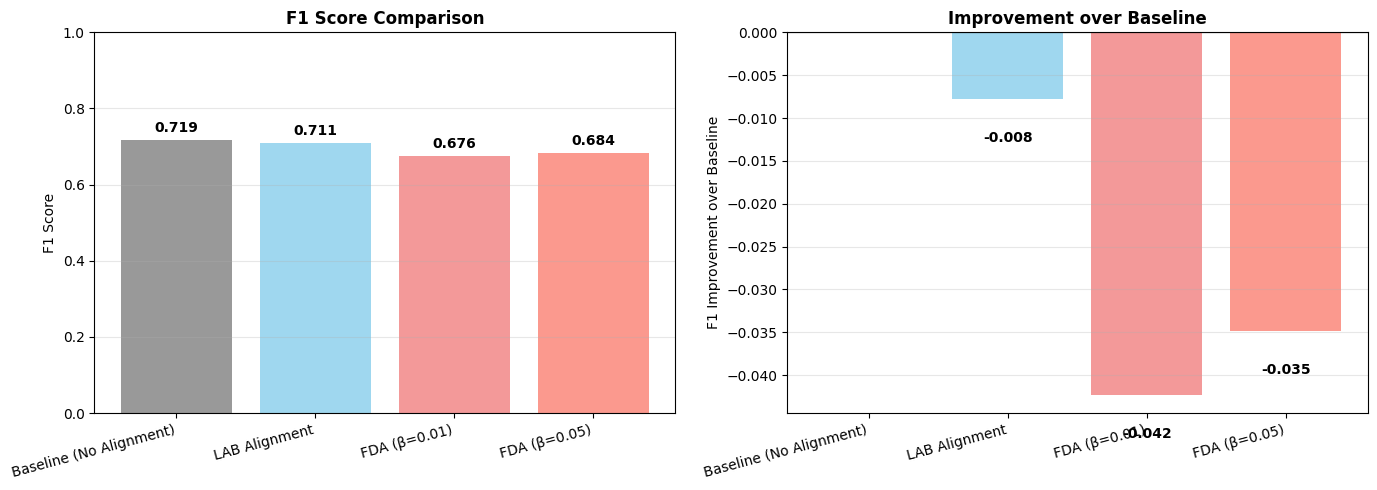

In [23]:
# Visualize results
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 scores
methods = df_summary['Method']
f1_scores = df_summary['F1 Score']
improvements = df_summary['F1 Improvement']

colors = ['gray', 'skyblue', 'lightcoral', 'salmon']
axes[0].bar(range(len(methods)), f1_scores, color=colors, alpha=0.8)
axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(methods, rotation=15, ha='right')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score Comparison', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Add values on bars
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Improvements
colors_imp = ['gray', 'skyblue', 'lightcoral', 'salmon']
axes[1].bar(range(len(methods)), improvements, color=colors_imp, alpha=0.8)
axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(methods, rotation=15, ha='right')
axes[1].set_ylabel('F1 Improvement over Baseline')
axes[1].set_title('Improvement over Baseline', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add values on bars
for i, v in enumerate(improvements):
    if v != 0:
        axes[1].text(i, v + 0.005 if v > 0 else v - 0.005, f'{v:+.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'input_alignment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Analysis & Conclusions

In [25]:
# Determine best method
best_idx = df_summary['F1 Score'].idxmax()
best_method = df_summary.iloc[best_idx]

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

print(f"\n🏆 Best Method: {best_method['Method']}")
print(f"   F1 Score: {best_method['F1 Score']:.4f}")
print(f"   Improvement: {best_method['F1 Improvement']:+.4f} ({best_method['F1 Improvement']/baseline_metrics['f1']*100:+.1f}%)")

print("\n📊 Method Comparison:")
if lab_metrics['f1'] > baseline_metrics['f1'] + 0.05:
    print("  ✅ LAB Alignment: Significant improvement (>5% F1)")
    print("     → Color statistics matching is effective")
elif lab_metrics['f1'] > baseline_metrics['f1']:
    print("  ⚠️ LAB Alignment: Modest improvement")
    print("     → Color shift exists but other factors matter too")
else:
    print("  ❌ LAB Alignment: No improvement")
    print("     → Domain shift is not purely color-based")

if max(fda001_metrics['f1'], fda005_metrics['f1']) > lab_metrics['f1'] + 0.02:
    print("  ✅ FDA: Outperforms LAB")
    print("     → Frequency domain transfer captures more complex shifts")
elif max(fda001_metrics['f1'], fda005_metrics['f1']) > baseline_metrics['f1']:
    print("  ⚠️ FDA: Works but similar to LAB")
    print("     → Both methods address same underlying shift")
else:
    print("  ❌ FDA: No improvement")
    print("     → Input-level alignment insufficient")

if fda005_metrics['f1'] > fda001_metrics['f1']:
    print("  📈 β=0.05 > β=0.01: More aggressive transfer helps")
else:
    print("  📉 β=0.01 ≥ β=0.05: Conservative transfer sufficient")

print("\n🎯 Thesis Implications:")
max_improvement = df_summary['F1 Improvement'].max()
if max_improvement > 0.10:
    print("  • Input-level alignment is HIGHLY effective")
    print("  • Domain shift is primarily abiotic (color/illumination)")
    print("  • This validates the 'Instagram filter' hypothesis")
    print("  • Thesis narrative: Input alignment > Feature adaptation")
elif max_improvement > 0.05:
    print("  • Input-level alignment provides moderate gains")
    print("  • Combining with TTA/few-shot may yield further improvement")
    print("  • Thesis narrative: Multi-level adaptation strategy")
else:
    print("  • Input-level alignment alone is insufficient")
    print("  • Domain shift includes biotic or structural differences")
    print("  • Thesis narrative: Need semantic adaptation or labeled data")


KEY FINDINGS

🏆 Best Method: Baseline (No Alignment)
   F1 Score: 0.7185
   Improvement: +0.0000 (+0.0%)

📊 Method Comparison:
  ❌ LAB Alignment: No improvement
     → Domain shift is not purely color-based
  ❌ FDA: No improvement
     → Input-level alignment insufficient
  📈 β=0.05 > β=0.01: More aggressive transfer helps

🎯 Thesis Implications:
  • Input-level alignment alone is insufficient
  • Domain shift includes biotic or structural differences
  • Thesis narrative: Need semantic adaptation or labeled data
